In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lib
from lib import data_dis, data_ref, data_vst

import numpy as np
from ksvd import ApproximateKSVD
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit

In [3]:
image_ref = np.fromfile('data/nu.bin', dtype=np.float64).reshape(100,100).T 
image_vst = np.fromfile('data/fz.bin', dtype=np.float64).reshape(100,100).T * 10
image_dis = np.fromfile('data/z.bin', dtype=np.float64).reshape(100,100).T 

In [4]:
results = {}
lib.filter_image(image_vst, results)

In [5]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from lpips import LPIPS
import torch
from DISTS_pytorch import DISTS

dists = DISTS()
lpips = LPIPS('vgg')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/alexkkir/anaconda3/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


/home/alexkkir/anaconda3/lib/python3.9/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


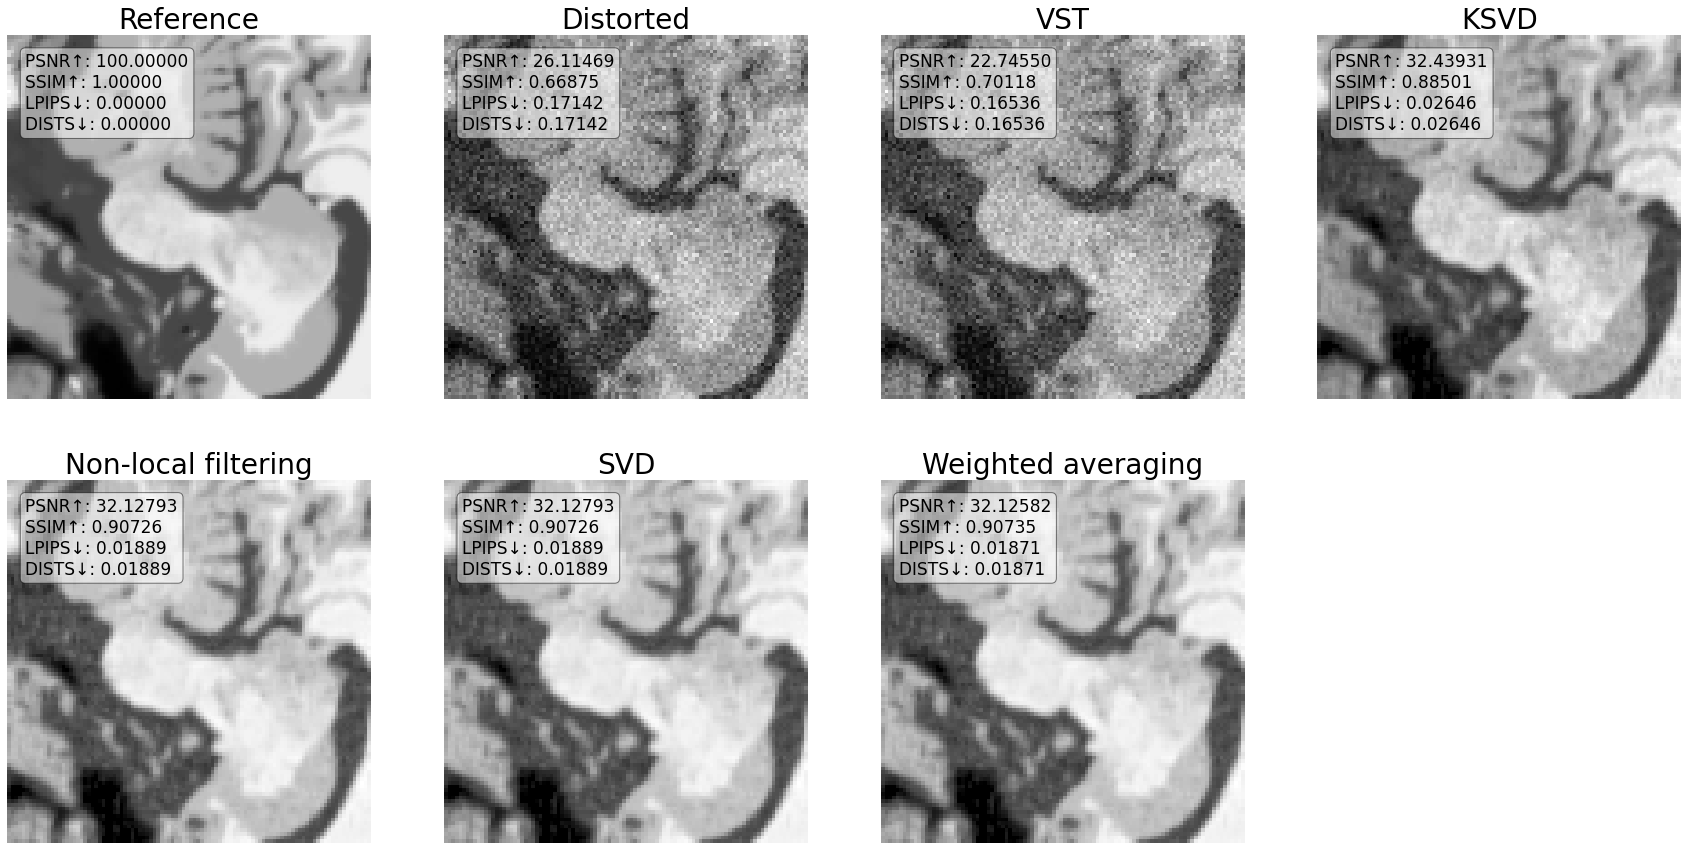

In [6]:
def calc_metrics(ref, dis):
    divider = 10

    ref = ref.astype('uint8')
    dis = dis.astype('uint8')

    # ref  = ref / ref.mean()
    # ref /= ref.std() * divider

    # dis = dis / dis.mean()
    # dis /= dis.std() * divider

    out = {}
    out['PSNR↑'] = min(100, peak_signal_noise_ratio(ref, dis))
    out['SSIM↑'] = structural_similarity(ref, dis)
    out['LPIPS↓'] = float(lpips(torch.Tensor(ref), torch.Tensor(dis))[0, 0, 0])
    out['DISTS↓'] = float(lpips(torch.Tensor(ref)[None, None, ...], torch.Tensor(dis))[0, 0, 0][None, None, ...])
    return out

def plot_results(results):
    fig, axs = plt.subplots(2, 4, figsize=(30, 15))
    axs = axs.ravel()

    map_names = {
        'reference': 'Reference',
        'distorted': 'Distorted',
        'vst': 'VST',
        'ksvd': 'KSVD',
        'nonlocal': 'Non-local filtering',
        'svd': 'SVD',
        'averaging': 'Weighted averaging',
        'Inverse VST': 'Inverse VST'
    }

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    for ax, name in zip(axs, results):
        ax.imshow(results[name], cmap='gray')
        ax.axis('off')
        ax.set_title(map_names[name], fontsize=28)

        metrics = calc_metrics(results['reference'], results[name])
        string = ""
        for metric, val in metrics.items():
            string += f"{metric}: {val:.5f}\n"
        string = string[:-1]
        ax.text(0.05, 0.95, string, transform=ax.transAxes, fontsize=17,
        verticalalignment='top', bbox=props)

    axs[-1].axis('off')

plot_results(results)
plt.savefig('results/pipeline/2.jpg')